In [6]:
import pandas as pd 

In [3]:
from openfisca_survey_manager.survey_collections import SurveyCollection
from openfisca_survey_manager.paths import default_config_files_directory as config_files_directory

In [3]:
from openfisca_france_indirect_taxation.build_survey_data.matching_bdf_entd.step_2_homogenize_variables import \
    create_niveau_vie_quantiles
from openfisca_france_indirect_taxation.build_survey_data.utils import \
    hellinger

data_entd, data_bdf = create_niveau_vie_quantiles(year_data = 2017)

In [37]:
def hellinger_variable(df1, df2, var, weight_col="pondmen"):
    # Vérification des colonnes
    for df in [df1, df2]:
        if var not in df.columns or weight_col not in df.columns:
            raise ValueError(f"La colonne '{var}' ou '{weight_col}' est manquante.")

    # Suppression des NaN
    df1 = df1.dropna(subset=[var, weight_col])
    df2 = df2.dropna(subset=[var, weight_col])

    # Conversion en numérique
    df1.loc[:, var] = pd.to_numeric(df1[var], errors='coerce')
    df2.loc[:, var] = pd.to_numeric(df2[var], errors='coerce')


    # Calcul des distributions
    categories = pd.Index(sorted(set(df1[var].unique()) | set(df2[var].unique())))
    dist1 = (df1.groupby(var)[weight_col].sum() / df1[weight_col].sum()).reindex(categories, fill_value=0)
    dist2 = (df2.groupby(var)[weight_col].sum() / df2[weight_col].sum()).reindex(categories, fill_value=0)

    # Calcul de la distance
    distance = hellinger(dist1.tolist(), dist2.tolist())

    return dist1, dist2, distance

In [36]:
data_bdf['agepr']

0        73
1        45
2        54
3        44
4        47
         ..
12076    59
12077    42
12078    45
12079    65
12080    51
Name: agepr, Length: 12081, dtype: object

In [65]:
set(data_entd.columns) | set(data_bdf.columns)

{'aba',
 'age_vehicule',
 'agepr',
 'cataeu',
 'coeffuc',
 'consommation',
 'cs42pr',
 'decile_rev',
 'dip14pr',
 'distance',
 'distance_autre_carbu',
 'distance_diesel',
 'distance_essence',
 'etat_veh_achat',
 'grande_ville',
 'ident_men',
 'km_autre_carbu',
 'km_diesel',
 'km_essence',
 'mloy_d',
 'moyenne_ville',
 'nactifs',
 'nb_diesel',
 'nb_essence',
 'nbphab',
 'nenfants',
 'niveau_vie',
 'niveau_vie_decile',
 'niveau_vie_quintile',
 'npers',
 'ocde10',
 'paris',
 'petite_ville',
 'pondmen',
 'poste_07_2_2_1',
 'prix_achat',
 'puissance',
 'rev_disponible',
 'revtot',
 'rural',
 'situapr',
 'stalog',
 'tau',
 'tuu',
 'typmen',
 'veh_tot',
 'vp_deplacements_pro',
 'vp_domicile_travail'}

In [61]:
dist1, dist2, hellinger_distance = hellinger_variable(data_bdf, data_entd, var = 'nb_essence', weight_col = 'pondmen')


In [62]:
hellinger_distance

0.05488435617684753

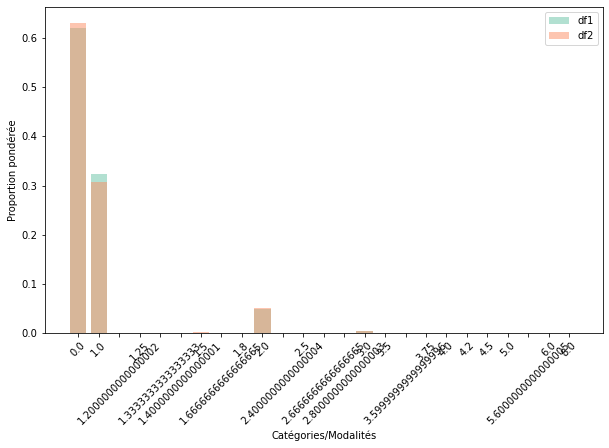

In [63]:
import matplotlib.pyplot as plt

# Convertir dist1 et dist2 en DataFrames pour facilité
df_dist1 = dist1.reset_index()
df_dist1.columns = ['valeur', 'proportion']

df_dist2 = dist2.reset_index()
df_dist2.columns = ['valeur', 'proportion']

# Tracer les distributions
plt.figure(figsize=(10, 6))
plt.bar(df_dist1['valeur'].astype(str), df_dist1['proportion'], alpha=0.5, label='df1')
plt.bar(df_dist2['valeur'].astype(str), df_dist2['proportion'], alpha=0.5, label='df2')
plt.xlabel('Catégories/Modalités')
plt.ylabel('Proportion pondérée')
plt.legend()
plt.xticks(rotation=45)
plt.show()
